In [1]:
import scipy as sp
import sklearn
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Preprocess data


In [2]:
from BeautifulSoup import BeautifulSoup

# PREPROCESS XML DOCUMENTS
def extract_from_xml(xml):
    bs = BeautifulSoup(xml)
    # tab na pocetku
    return [document.text.rstrip('\t') for document in bs.findAll('document')]


def remove_special_data(text):
    # TODO if needed
    return text

Strukture za pohranu dataseta

In [3]:
LABELS = ['userid', 'gender', 'age_group',
          'extroverted', 'stable', 'agreeable',
          'conscientious', 'open']

''' User class used to store parsed data'''
class User(object):

    def __init__(self, line):
        self.labels = LABELS

        parts = map(str.strip, line.split(FIELDS_DELIMITER))
        if len(parts) == 1:
            parts = [parts[0]] + [''] * 7

        self.userid = parts[0]
        self.gender = parts[1]
        self.age_group = parts[2]

        self.extroverted = parts[3]
        self.stable = parts[4]
        self.agreeable = parts[5]
        self.conscientious = parts[6]
        self.open = parts[7]
        self.documents = []

    def user_details(self):
        return [self.userid, self.gender,
                self.age_group, self.extroverted, self.stable,
                self.agreeable, self.conscientious, self.open]

    def user_documents(self):
        return self.documents





In [4]:
TRUTH_FILE = 'truth.txt'
FIELDS_DELIMITER = ':::'
LABELS = ['userid', 'gender', 'age_group',
          'extroverted', 'stable', 'agreeable',
          'conscientious', 'open']

'''Dataset wrapper - parses, cleans and stores user data (documents and truth)
'''
class Dataset(object):

    def __init__(self, path):
        if not os.path.exists(path) or not os.path.isdir(path):
            raise Exception('No such dir ' + path)

        self.path = path
        self.users = {}
        self.X = []
        self.y = []
        self.load()
        self.labels = LABELS

    def load(self):
        user_files = filter(lambda name: name != TRUTH_FILE, os.listdir(self.path))
        truth = os.path.join(self.path, TRUTH_FILE)
        assert os.path.isfile(truth)

        # load truth
        with open(truth, 'r') as f:
            for line in f:
                user = User(line)
                self.users[user.userid] = user

        # load texts
        for path in user_files:
            user = os.path.splitext(path)[0]
            path = os.path.join(self.path, path)

            with open(path, 'r') as xml:
                content = extract_from_xml(xml.read())
                if not self.users.has_key(user):
                    self.users[user] = User(user)
                self.users[user].documents = map(remove_special_data, content)

    def store_as_samples(self):
        for id, user in self.users.items():
            self.X.append('\n'.join(user.documents))
            self.y.append(np.array(user.user_details()))

        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def get_samples(self, feature='all'):
        if feature == 'all':
            return self.X, self.y

        feature_col = [i for i, lab in enumerate(self.labels) if lab == feature]
        if len(feature_col):
            feature_col = feature_col[0]
        else:
            raise Exception('Invalid feature %s\nValid features %s' %
                            (feature, ', '.join(self.labels)))

        return self.X, self.y[:, feature_col]



Pomocni razredi

In [5]:
from sklearn.base import TransformerMixin
'''Transformes sparse matrix to dense - ex. for NaiveBayes'''
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [6]:
#simple demo

dataset_path = './dataset/english'
d = Dataset(dataset_path)
d.store_as_samples() #transforme data to X, y

X, y = d.get_samples('age_group')


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import  GaussianNB
from sklearn.pipeline import  Pipeline 


vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
svcPipe = Pipeline([('vectorize', vectorize), ('densen', DenseTransformer()), ('svc', LinearSVC())])
bayesPipe = Pipeline([('vectorize', vectorize), ('densen', DenseTransformer()), ('bayes', GaussianNB())])

svcPipe.fit(X, y)
print 'SVC training score %s' % svcPipe.score(X, y)
                    

bayesPipe.fit(X, y)
print 'Bayes training score %s' % bayesPipe.score(X, y)

# without pipeline
#vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
#X = vectorize.fit_transform(X)
#model = LinearSVC()
#model.fit(X,y)
#print model.score(X, y)

SVC training score 0.993421052632
Bayes training score 1.0


In [8]:
# below code taken and adapted from example
# @ http://scikit-learn.org/stable/auto_examples/plot_learning_curve.html
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,precision_recall_curve


#TODO jos dodati ovaj precision_recall_curve, pokazivali na predavanjima cini se korisno
def printScore(y_true,y_pred,average='micro'):
    print average+" scores:"
    print "\t P  = %s" % precision_score(y_true,y_pred,average=average)
    print "\t R  = %s" % recall_score(y_true,y_pred,average=average)
    print "\t F1 = %s" % f1_score(y_true,y_pred,average=average)


def modelEvaluator(X, y, model, parameters, scoring = None, num_flods = 3,test_size = 0.3,ylim=None,train_sizes_lncurv=np.linspace(.1, 1.0, 10)):
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    grid_cv = GridSearchCV( model, parameters, scoring = scoring, n_jobs = -1, verbose = 1, cv = num_flods)
    grid_cv.fit(X_train,y_train)
    
    print 'Model best_params: %s' % grid_cv.best_params_
    estimator = grid_cv.best_estimator_
    print 'Model acc : %s' % estimator.score(X_test,y_test)
    
    y_pred = estimator.predict(X_test)
    
    print "Confusion matrix:\n %s" % confusion_matrix(y_test,y_pred)
    
    #TODO trebaju biti binarne, problem onda treba minjati OVO i OVR 
    #precision, recall, _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
    #plt.plot(precision,recall)
    
    if scoring == None:
            printScore(y_test,y_pred,'macro')
            printScore(y_test,y_pred)
    
    plot_learning_curve(estimator, "Test", X, y,  ylim=ylim, cv=num_flods,train_sizes=train_sizes_lncurv)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   1 out of  12 | elapsed:    0.1s remaining:    0.7s


Model best_params: {'kernel': 'linear', 'C': 10000000}
Model acc : 0.97962962963
Confusion matrix:
 [[53  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  1 52  0  1  0  0  0  0]
 [ 0  1  0  0 59  0  0  0  0  0]
 [ 0  0  0  0  0 64  0  1  0  1]
 [ 0  0  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  1]
 [ 0  0  0  0  0  1  0  0 42  0]
 [ 0  0  0  0  1  0  0  1  1 56]]
macro scores:
	 P  = 0.979654537991
	 R  = 0.980370817623
	 F1 = 0.979939123433
micro scores:
	 P  = 0.97962962963
	 R  = 0.97962962963
	 F1 = 0.97962962963


[Parallel(n_jobs=-1)]: Done  11 out of  12 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished


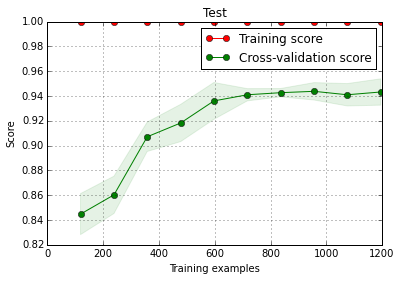

In [10]:
from sklearn.datasets import load_digits
from sklearn import svm
from sklearn.preprocessing import label_binarize


digits = load_digits()
X, y = digits.data, digits.target

parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 10000000]}
model = svm.SVC()
modelEvaluator(X, y, model, parameters)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import  GaussianNB
from sklearn.pipeline import  Pipeline 


vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
svcPipe = Pipeline([('vectorize', vectorize), ('svc', SVC())])
bayesPipe = Pipeline([('vectorize', vectorize), ('densen', DenseTransformer()), ('bayes', GaussianNB())])

parameters = { 'C':linspace(0.001, 10000000,1000)}
X, y = d.get_samples('age_group')

vectorize = TfidfVectorizer(analyzer='char', ngram_range=(3,3))
Xvec = vectorize.fit_transform(X)

modelEvaluator(Xvec, y, LinearSVC(), parameters)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 200 jobs       | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 450 jobs       | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 800 jobs       | elapsed:  2.2min
